In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score,accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [35]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from PyBioMed.PyMolecule.cats2d import CATS2D
from PyBioMed.PyMolecule import cats2d


In [36]:
def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 100
    cnt = 0
    new_smiles_list = []
    for i in smiles_list:
        cnt+=1
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 65))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:65] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
            new_smiles_list.append(i)
        else :
            print("Molecule is too big")
            adj_norm.append()
            
    features = np.asarray(features)
    adj = np.asarray(adj)
    # ensure the the length is the same as the input
    assert len(features) == len(smiles_list)
    return features, adj, new_smiles_list

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding(atom.GetTotalValence(), [0, 1, 2, 3, 4, 5, 6]) + [atom.GetIsAromatic()] + get_ring_info(atom))

def get_ring_info(atom):
    ring_info_feature = []
    for i in range(3, 9):
        if atom.IsInRingSize(i):
            ring_info_feature.append(1)
        else:
            ring_info_feature.append(0)
    return ring_info_feature

MODEL de GNN

In [ ]:

class GraphNeuralNetwork(nn.Module):
    def __init__(self, num_features, hidden_channels, num_gcn_layers, 
                 dnn_hidden_nodes, num_dnn_layers, dropout_rate, l2_lambda, num_classes=1):
        """
        Enhanced Graph Neural Network with adaptive batch normalization
        """
        super(GraphNeuralNetwork, self).__init__()
        
        # Regularization parameters
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        
        # Graph Convolution Layers
        self.gcn_layers = nn.ModuleList()
        
        # Input layer
        self.gcn_layers.append(
            nn.Sequential(
                nn.Linear(num_features, hidden_channels),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_channels, momentum=0.1),
                nn.Dropout(dropout_rate)
            )
        )
        
        # Add GCN layers
        for _ in range(num_gcn_layers - 1):
            self.gcn_layers.append(
                nn.Sequential(
                    nn.Linear(hidden_channels, hidden_channels),
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_channels, momentum=0.1),
                    nn.Dropout(dropout_rate)
                )
            )
        
        # Hidden Layers
        self.dnn_layers = nn.ModuleList()
        input_size = hidden_channels
        
        for _ in range(num_dnn_layers):
            self.dnn_layers.append(
                nn.Sequential(
                    nn.Linear(input_size, dnn_hidden_nodes),
                    nn.ReLU(),
                    nn.BatchNorm1d(dnn_hidden_nodes, momentum=0.1),
                    nn.Dropout(dropout_rate)
                )
            )
            input_size = dnn_hidden_nodes
        
        # Final output layer
        self.output_layer = nn.Linear(input_size, num_classes)
    
    def graph_convolution(self, X, A):
        """
        Enhanced graph convolution with adjacency normalization
        """
        # Normalize adjacency matrix
        degrees = torch.sum(A, dim=2)
        D_inv_sqrt = torch.pow(degrees + 1e-7, -0.5)
        A_norm = A * D_inv_sqrt.unsqueeze(-1) * D_inv_sqrt.unsqueeze(-2)
        
        for layer in self.gcn_layers:
            # Linear transformation
            X = layer[0](X)
            
            # Message passing
            X = torch.bmm(A_norm, X)
            
            # Activation
            X = layer[1](X)
            
            # Batch normalization 
            X = layer[2](X.transpose(1, 2)).transpose(1, 2)

            # Dropout
            X = layer[3](X)
        
        return X
    
    def forward(self, X, A):
        """
        Forward pass with graph convolution and regularization
        """
        # Graph convolution
        X = self.graph_convolution(X, A)
        
        # Global pooling
        X = torch.mean(X, dim=1)
        
        # Dense layers
        for layer in self.dnn_layers:
            X = layer[0](X)  # Linear
            X = layer[1](X)  # ReLU
            X = layer[2](X)  # BatchNorm
            X = layer[3](X)  # Dropout
        
        # Output layer
        return self.output_layer(X)


class GraphDataset(Dataset):
    def __init__(self, X_data, A_data, y_data):
        """
        Dataset with tensor conversion
        """
        self.X = torch.tensor(X_data, dtype=torch.float32)
        self.A = torch.tensor(A_data, dtype=torch.float32)
        self.y = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.A[idx], self.y[idx]


def train_graph_neural_network(
    model, train_loader,test_loader, val_loader=None, 
    epochs=100, 
    learning_rate=0.001, 
    weight_decay=1e-5, 
    patience=10, 
    save_path="gnn_model.pth"
):
    """
    Training function with early stopping and validation
    """
    # Optimizer with weight decay
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    
    epoches=[]
    kappa = []
    kappa_mean = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        train_preds = []
        train_true = []
        
        for X_batch, A_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            outputs = model(X_batch, A_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            train_preds.extend(torch.sigmoid(outputs).detach().numpy())
            train_true.extend(y_batch.numpy())
        
        # Validation phase
        if val_loader:
            model.eval()
            val_losses = []
            val_preds = []
            val_true = []
            
            with torch.no_grad():
                for X_batch, A_batch, y_batch in val_loader:
                    outputs = model(X_batch, A_batch)
                    loss = criterion(outputs, y_batch)
                    val_losses.append(loss.item())
                    
                    val_preds.extend(torch.sigmoid(outputs).numpy())
                    val_true.extend(y_batch.numpy())
            
            # Compute metrics
            val_loss = np.mean(val_losses)
            val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
            
            # Logging and early stopping
            print(f"Epoch {epoch+1}: Val Loss {val_loss:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
            else:
                patience_counter += 1
            
            # Learning rate scheduling
            scheduler.step(val_loss)
            
            # # Early stopping
            # if patience_counter >= patience:
            #     print(f"Early stopping at epoch {epoch+1}")
            #     break
        D=evaluate_graph_neural_network(model, test_loader)
        kappa.append(D['Cohens_kappa'])
        
        if epoch % 10 == 0 or epoch == epochs - 1:
            epoches.append(epoch + 1)
            kappa_mean.append(np.mean(kappa))
            kappa = []
            plt.plot(epoches, kappa_mean, label='Cohen\'s Kappa')
            plt.show()
            
    return model


def evaluate_graph_neural_network(model, dataloader):
    """
    Comprehensive model evaluation
    """
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for X_batch, A_batch, y_batch in dataloader:
            outputs = model(X_batch, A_batch)
            preds = torch.sigmoid(outputs).numpy().squeeze()
            preds_binary = (preds > 0.5).astype(int)
            
            all_preds.extend(preds_binary)
            all_true.extend(y_batch.numpy())
    
    #Compute metrics
    accuracy = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds)
    recall = recall_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds)
    kappa = cohen_kappa_score(all_true, all_preds)
    
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"F1 Score: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'Cohens_kappa': kappa
    }


MAIN

Epoch 1: 100%|██████████| 236/236 [00:09<00:00, 26.01it/s]


Cohen's Kappa: 0.3538


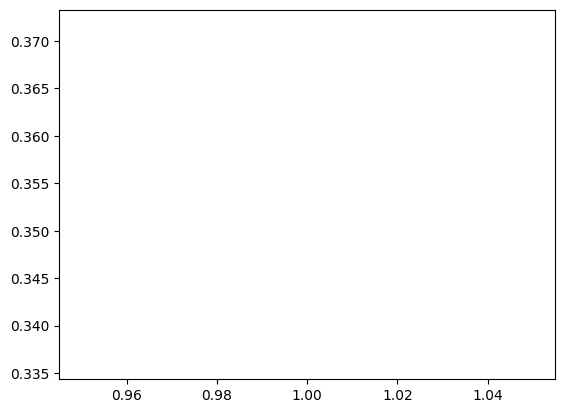

Epoch 2: 100%|██████████| 236/236 [00:08<00:00, 27.23it/s]


Cohen's Kappa: 0.4059


Epoch 3: 100%|██████████| 236/236 [00:08<00:00, 27.90it/s]


Cohen's Kappa: 0.4116


Epoch 4: 100%|██████████| 236/236 [00:08<00:00, 28.63it/s]


Cohen's Kappa: 0.4303


Epoch 5: 100%|██████████| 236/236 [00:08<00:00, 28.50it/s]


Cohen's Kappa: 0.4269


Epoch 6: 100%|██████████| 236/236 [00:08<00:00, 28.19it/s]


Cohen's Kappa: 0.4821


Epoch 7: 100%|██████████| 236/236 [00:08<00:00, 28.72it/s]


Cohen's Kappa: 0.4612


Epoch 8: 100%|██████████| 236/236 [00:08<00:00, 28.02it/s]


Cohen's Kappa: 0.4772


Epoch 9: 100%|██████████| 236/236 [00:08<00:00, 28.59it/s]


Cohen's Kappa: 0.5271


Epoch 10: 100%|██████████| 236/236 [00:08<00:00, 28.24it/s]


Cohen's Kappa: 0.5273


Epoch 11: 100%|██████████| 236/236 [00:08<00:00, 28.58it/s]


Cohen's Kappa: 0.5445


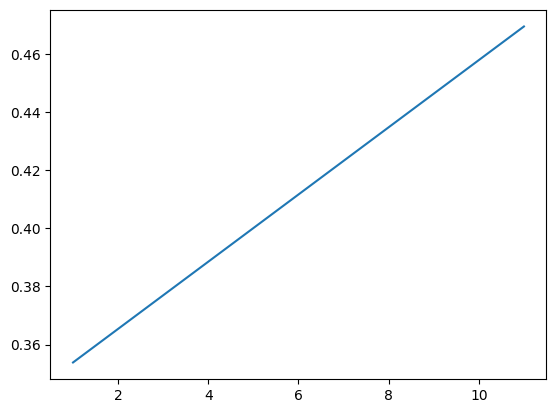

Epoch 12: 100%|██████████| 236/236 [00:08<00:00, 27.39it/s]


Cohen's Kappa: 0.4673


Epoch 13: 100%|██████████| 236/236 [00:08<00:00, 27.54it/s]


Cohen's Kappa: 0.5164


Epoch 14: 100%|██████████| 236/236 [00:08<00:00, 28.82it/s]


Cohen's Kappa: 0.5170


Epoch 15: 100%|██████████| 236/236 [00:08<00:00, 28.35it/s]


Cohen's Kappa: 0.4967


Epoch 16: 100%|██████████| 236/236 [00:08<00:00, 28.66it/s]


Cohen's Kappa: 0.5370


Epoch 17: 100%|██████████| 236/236 [00:08<00:00, 28.55it/s]


Cohen's Kappa: 0.5253


Epoch 18: 100%|██████████| 236/236 [00:08<00:00, 28.89it/s]


Cohen's Kappa: 0.5427


Epoch 19: 100%|██████████| 236/236 [00:08<00:00, 28.83it/s]


Cohen's Kappa: 0.5555


Epoch 20: 100%|██████████| 236/236 [00:08<00:00, 29.00it/s]


Cohen's Kappa: 0.5495


Epoch 21: 100%|██████████| 236/236 [00:08<00:00, 28.76it/s]


Cohen's Kappa: 0.5683


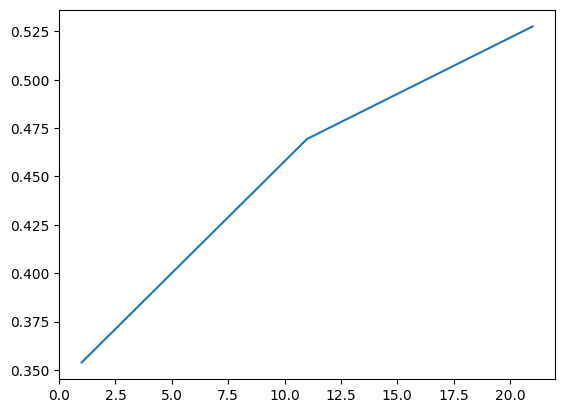

Epoch 22: 100%|██████████| 236/236 [00:08<00:00, 27.65it/s]


Cohen's Kappa: 0.5647


Epoch 23: 100%|██████████| 236/236 [00:08<00:00, 27.62it/s]


Cohen's Kappa: 0.5782


Epoch 24: 100%|██████████| 236/236 [00:08<00:00, 27.67it/s]


Cohen's Kappa: 0.5484


Epoch 25: 100%|██████████| 236/236 [00:08<00:00, 27.60it/s]


Cohen's Kappa: 0.5670


Epoch 26: 100%|██████████| 236/236 [00:08<00:00, 27.52it/s]


Cohen's Kappa: 0.5824


Epoch 27: 100%|██████████| 236/236 [00:08<00:00, 27.46it/s]


Cohen's Kappa: 0.5548


Epoch 28: 100%|██████████| 236/236 [00:09<00:00, 25.67it/s]


Cohen's Kappa: 0.5804


Epoch 29: 100%|██████████| 236/236 [00:09<00:00, 25.11it/s]


Cohen's Kappa: 0.5738


Epoch 30: 100%|██████████| 236/236 [00:08<00:00, 26.98it/s]


Cohen's Kappa: 0.5651


Epoch 31: 100%|██████████| 236/236 [00:09<00:00, 25.67it/s]


Cohen's Kappa: 0.5705


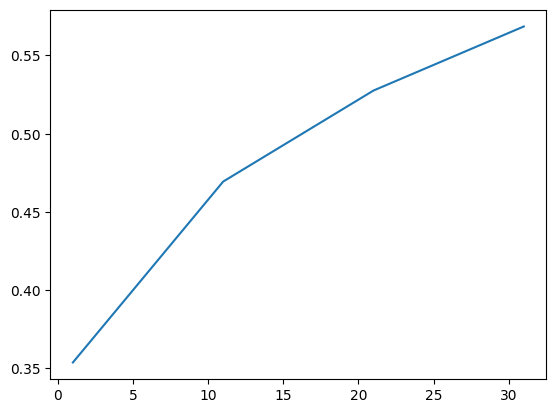

Epoch 32: 100%|██████████| 236/236 [00:08<00:00, 27.77it/s]


Cohen's Kappa: 0.5777


Epoch 33: 100%|██████████| 236/236 [00:08<00:00, 26.82it/s]


Cohen's Kappa: 0.5838


Epoch 34: 100%|██████████| 236/236 [00:08<00:00, 26.37it/s]


Cohen's Kappa: 0.5754


Epoch 35: 100%|██████████| 236/236 [00:08<00:00, 26.46it/s]


Cohen's Kappa: 0.5625


Epoch 36: 100%|██████████| 236/236 [00:08<00:00, 27.26it/s]


Cohen's Kappa: 0.5639


Epoch 37: 100%|██████████| 236/236 [00:08<00:00, 26.31it/s]


Cohen's Kappa: 0.5717


Epoch 38: 100%|██████████| 236/236 [00:08<00:00, 27.42it/s]


Cohen's Kappa: 0.5850


Epoch 39: 100%|██████████| 236/236 [00:08<00:00, 27.12it/s]


Cohen's Kappa: 0.5621


Epoch 40: 100%|██████████| 236/236 [00:08<00:00, 27.38it/s]


Cohen's Kappa: 0.5726


Epoch 41: 100%|██████████| 236/236 [00:08<00:00, 27.90it/s]


Cohen's Kappa: 0.5745


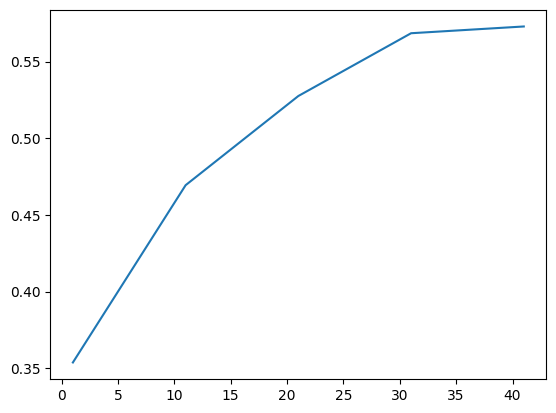

Epoch 42: 100%|██████████| 236/236 [00:08<00:00, 27.11it/s]


Cohen's Kappa: 0.5981


Epoch 43: 100%|██████████| 236/236 [00:08<00:00, 27.83it/s]


Cohen's Kappa: 0.5825


Epoch 44: 100%|██████████| 236/236 [00:08<00:00, 27.38it/s]


Cohen's Kappa: 0.5747


Epoch 45: 100%|██████████| 236/236 [00:08<00:00, 27.67it/s]


Cohen's Kappa: 0.5711


Epoch 46: 100%|██████████| 236/236 [00:08<00:00, 27.83it/s]


Cohen's Kappa: 0.5559


Epoch 47: 100%|██████████| 236/236 [00:09<00:00, 26.03it/s]


Cohen's Kappa: 0.5869


Epoch 48: 100%|██████████| 236/236 [00:08<00:00, 27.46it/s]


Cohen's Kappa: 0.5883


Epoch 49: 100%|██████████| 236/236 [00:08<00:00, 27.69it/s]


Cohen's Kappa: 0.5737


Epoch 50: 100%|██████████| 236/236 [00:08<00:00, 27.97it/s]


Cohen's Kappa: 0.5774


Epoch 51: 100%|██████████| 236/236 [00:08<00:00, 27.92it/s]


Cohen's Kappa: 0.5904


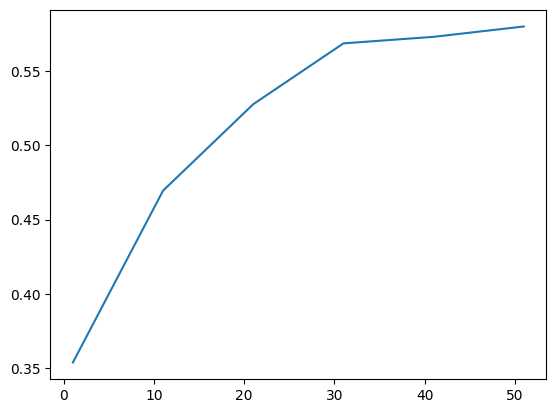

Epoch 52: 100%|██████████| 236/236 [00:08<00:00, 27.96it/s]


Cohen's Kappa: 0.5744


Epoch 53: 100%|██████████| 236/236 [00:08<00:00, 28.19it/s]


Cohen's Kappa: 0.5868


Epoch 54: 100%|██████████| 236/236 [00:08<00:00, 27.67it/s]


Cohen's Kappa: 0.5966


Epoch 55: 100%|██████████| 236/236 [00:08<00:00, 28.05it/s]


Cohen's Kappa: 0.5800


Epoch 56: 100%|██████████| 236/236 [00:08<00:00, 27.00it/s]


Cohen's Kappa: 0.5969


Epoch 57: 100%|██████████| 236/236 [00:08<00:00, 27.77it/s]


Cohen's Kappa: 0.6025


Epoch 58: 100%|██████████| 236/236 [00:08<00:00, 27.82it/s]


Cohen's Kappa: 0.5959


Epoch 59: 100%|██████████| 236/236 [00:08<00:00, 27.76it/s]


Cohen's Kappa: 0.5844


Epoch 60: 100%|██████████| 236/236 [00:08<00:00, 27.76it/s]


Cohen's Kappa: 0.6054


Epoch 61: 100%|██████████| 236/236 [00:08<00:00, 27.92it/s]


Cohen's Kappa: 0.5907


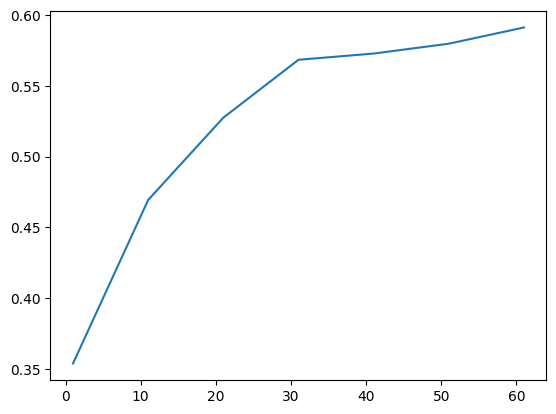

Epoch 62: 100%|██████████| 236/236 [00:08<00:00, 26.85it/s]


Cohen's Kappa: 0.5947


Epoch 63: 100%|██████████| 236/236 [00:08<00:00, 27.42it/s]


Cohen's Kappa: 0.6034


Epoch 64: 100%|██████████| 236/236 [00:08<00:00, 27.55it/s]


Cohen's Kappa: 0.5898


Epoch 65: 100%|██████████| 236/236 [00:08<00:00, 27.78it/s]


Cohen's Kappa: 0.6025


Epoch 66: 100%|██████████| 236/236 [00:08<00:00, 27.45it/s]


Cohen's Kappa: 0.6053


Epoch 67: 100%|██████████| 236/236 [00:08<00:00, 27.56it/s]


Cohen's Kappa: 0.5992


Epoch 68: 100%|██████████| 236/236 [00:08<00:00, 27.44it/s]


Cohen's Kappa: 0.5919


Epoch 69: 100%|██████████| 236/236 [00:08<00:00, 27.64it/s]


Cohen's Kappa: 0.5862


Epoch 70: 100%|██████████| 236/236 [00:08<00:00, 27.55it/s]


Cohen's Kappa: 0.5920


Epoch 71: 100%|██████████| 236/236 [00:08<00:00, 27.72it/s]


Cohen's Kappa: 0.6080


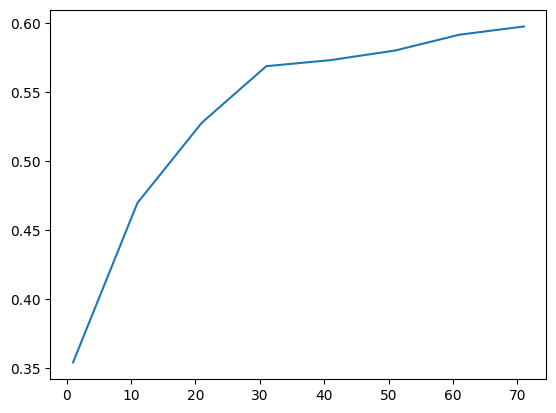

Epoch 72: 100%|██████████| 236/236 [00:08<00:00, 27.81it/s]


Cohen's Kappa: 0.5778


Epoch 73: 100%|██████████| 236/236 [00:08<00:00, 27.59it/s]


Cohen's Kappa: 0.5890


Epoch 74: 100%|██████████| 236/236 [00:08<00:00, 27.89it/s]


Cohen's Kappa: 0.5866


Epoch 75: 100%|██████████| 236/236 [00:08<00:00, 27.16it/s]


Cohen's Kappa: 0.6019


Epoch 76: 100%|██████████| 236/236 [00:08<00:00, 27.82it/s]


Cohen's Kappa: 0.6160


Epoch 77: 100%|██████████| 236/236 [00:08<00:00, 27.50it/s]


Cohen's Kappa: 0.6101


Epoch 78: 100%|██████████| 236/236 [00:08<00:00, 27.64it/s]


Cohen's Kappa: 0.5931


Epoch 79: 100%|██████████| 236/236 [00:08<00:00, 27.79it/s]


Cohen's Kappa: 0.5972


Epoch 80: 100%|██████████| 236/236 [00:08<00:00, 27.53it/s]


Cohen's Kappa: 0.6139


Epoch 81: 100%|██████████| 236/236 [00:08<00:00, 27.67it/s]


Cohen's Kappa: 0.5894


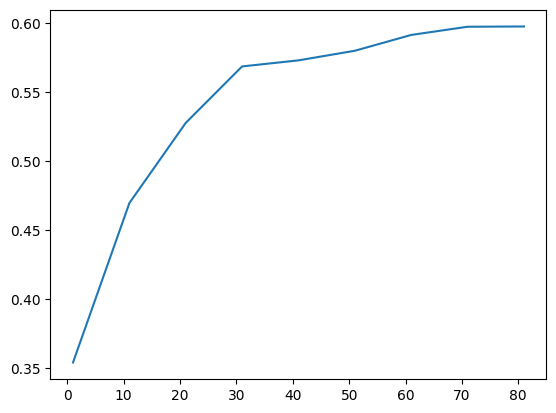

Epoch 82: 100%|██████████| 236/236 [00:08<00:00, 27.27it/s]


Cohen's Kappa: 0.6097


Epoch 83: 100%|██████████| 236/236 [00:08<00:00, 27.81it/s]


Cohen's Kappa: 0.6059


Epoch 84: 100%|██████████| 236/236 [00:08<00:00, 27.58it/s]


Cohen's Kappa: 0.6100


Epoch 85: 100%|██████████| 236/236 [00:08<00:00, 28.01it/s]


Cohen's Kappa: 0.5896


Epoch 86: 100%|██████████| 236/236 [00:08<00:00, 27.70it/s]


Cohen's Kappa: 0.6048


Epoch 87: 100%|██████████| 236/236 [00:08<00:00, 27.79it/s]


Cohen's Kappa: 0.5942


Epoch 88: 100%|██████████| 236/236 [00:08<00:00, 27.93it/s]


Cohen's Kappa: 0.6035


Epoch 89: 100%|██████████| 236/236 [00:08<00:00, 26.89it/s]


Cohen's Kappa: 0.6053


Epoch 90: 100%|██████████| 236/236 [00:08<00:00, 27.53it/s]


Cohen's Kappa: 0.6089


Epoch 91: 100%|██████████| 236/236 [00:08<00:00, 26.67it/s]


Cohen's Kappa: 0.6105


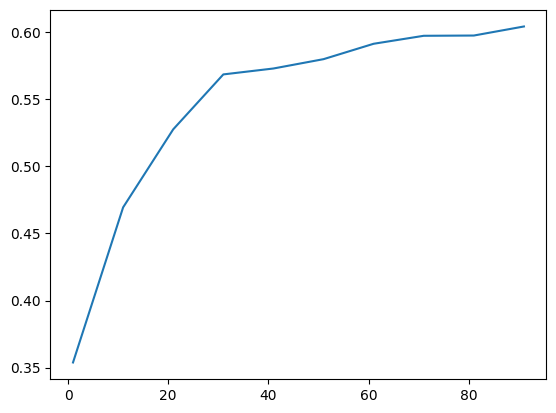

Epoch 92: 100%|██████████| 236/236 [00:08<00:00, 26.86it/s]


Cohen's Kappa: 0.6067


Epoch 93: 100%|██████████| 236/236 [00:09<00:00, 26.09it/s]


Cohen's Kappa: 0.6121


Epoch 94: 100%|██████████| 236/236 [00:08<00:00, 28.38it/s]


Cohen's Kappa: 0.6127


Epoch 95: 100%|██████████| 236/236 [00:08<00:00, 26.44it/s]


Cohen's Kappa: 0.6160


Epoch 96: 100%|██████████| 236/236 [00:08<00:00, 27.19it/s]


Cohen's Kappa: 0.6137


Epoch 97: 100%|██████████| 236/236 [00:09<00:00, 25.26it/s]


Cohen's Kappa: 0.6132


Epoch 98: 100%|██████████| 236/236 [00:09<00:00, 25.18it/s]


Cohen's Kappa: 0.6248


Epoch 99: 100%|██████████| 236/236 [00:08<00:00, 26.53it/s]


Cohen's Kappa: 0.6199


Epoch 100: 100%|██████████| 236/236 [00:08<00:00, 27.60it/s]


Cohen's Kappa: 0.6077


Epoch 101: 100%|██████████| 236/236 [00:09<00:00, 25.98it/s]


Cohen's Kappa: 0.6177


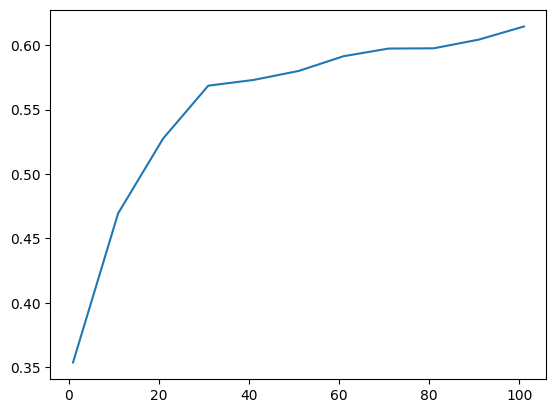

Epoch 102: 100%|██████████| 236/236 [00:08<00:00, 26.82it/s]


Cohen's Kappa: 0.6155


Epoch 103: 100%|██████████| 236/236 [00:08<00:00, 27.53it/s]


Cohen's Kappa: 0.6077


Epoch 104: 100%|██████████| 236/236 [00:08<00:00, 27.27it/s]


Cohen's Kappa: 0.6025


Epoch 105: 100%|██████████| 236/236 [00:08<00:00, 27.47it/s]


Cohen's Kappa: 0.6130


Epoch 106: 100%|██████████| 236/236 [00:08<00:00, 27.45it/s]


Cohen's Kappa: 0.6159


Epoch 107: 100%|██████████| 236/236 [00:08<00:00, 26.55it/s]


Cohen's Kappa: 0.6095


Epoch 108: 100%|██████████| 236/236 [00:08<00:00, 27.46it/s]


Cohen's Kappa: 0.6255


Epoch 109: 100%|██████████| 236/236 [00:08<00:00, 27.39it/s]


Cohen's Kappa: 0.6204


Epoch 110: 100%|██████████| 236/236 [00:08<00:00, 27.65it/s]


Cohen's Kappa: 0.6148


Epoch 111: 100%|██████████| 236/236 [00:08<00:00, 27.36it/s]


Cohen's Kappa: 0.6030


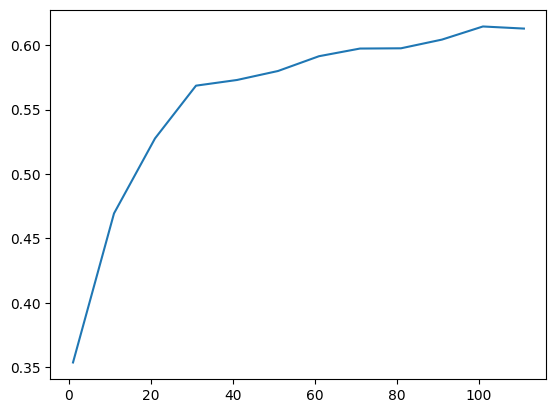

Epoch 112: 100%|██████████| 236/236 [00:08<00:00, 27.26it/s]


Cohen's Kappa: 0.6088


Epoch 113: 100%|██████████| 236/236 [00:08<00:00, 26.51it/s]


Cohen's Kappa: 0.6228


Epoch 114: 100%|██████████| 236/236 [00:08<00:00, 26.64it/s]


Cohen's Kappa: 0.6248


Epoch 115: 100%|██████████| 236/236 [00:08<00:00, 26.59it/s]


Cohen's Kappa: 0.6208


Epoch 116: 100%|██████████| 236/236 [00:08<00:00, 27.07it/s]


Cohen's Kappa: 0.6270


Epoch 117: 100%|██████████| 236/236 [00:08<00:00, 27.43it/s]


Cohen's Kappa: 0.6185


Epoch 118: 100%|██████████| 236/236 [00:08<00:00, 27.28it/s]


Cohen's Kappa: 0.6128


Epoch 119: 100%|██████████| 236/236 [00:08<00:00, 27.30it/s]


Cohen's Kappa: 0.6175


Epoch 120: 100%|██████████| 236/236 [00:08<00:00, 27.23it/s]


Cohen's Kappa: 0.6109


Epoch 121: 100%|██████████| 236/236 [00:08<00:00, 27.57it/s]


Cohen's Kappa: 0.6370


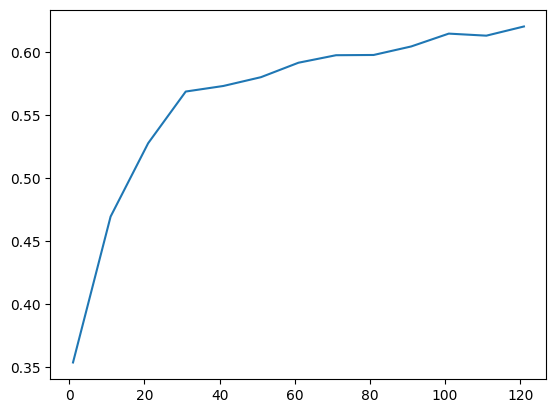

Epoch 122: 100%|██████████| 236/236 [00:08<00:00, 27.77it/s]


Cohen's Kappa: 0.6322


Epoch 123: 100%|██████████| 236/236 [00:08<00:00, 26.92it/s]


Cohen's Kappa: 0.6180


Epoch 124: 100%|██████████| 236/236 [00:08<00:00, 27.06it/s]


Cohen's Kappa: 0.6227


Epoch 125: 100%|██████████| 236/236 [00:08<00:00, 27.42it/s]


Cohen's Kappa: 0.6072


Epoch 126: 100%|██████████| 236/236 [00:08<00:00, 27.58it/s]


Cohen's Kappa: 0.6065


Epoch 127: 100%|██████████| 236/236 [00:08<00:00, 27.76it/s]


Cohen's Kappa: 0.6192


Epoch 128: 100%|██████████| 236/236 [00:08<00:00, 27.51it/s]


Cohen's Kappa: 0.6050


Epoch 129: 100%|██████████| 236/236 [00:08<00:00, 26.43it/s]


Cohen's Kappa: 0.6084


Epoch 130: 100%|██████████| 236/236 [00:08<00:00, 27.64it/s]


Cohen's Kappa: 0.6142


Epoch 131: 100%|██████████| 236/236 [00:08<00:00, 27.42it/s]


Cohen's Kappa: 0.6150


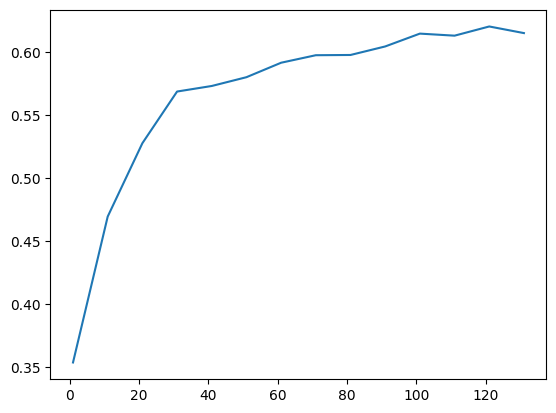

Epoch 132: 100%|██████████| 236/236 [00:08<00:00, 26.59it/s]


Cohen's Kappa: 0.6065


Epoch 133: 100%|██████████| 236/236 [00:08<00:00, 27.46it/s]


Cohen's Kappa: 0.6314


Epoch 134: 100%|██████████| 236/236 [00:08<00:00, 27.36it/s]


Cohen's Kappa: 0.6215


Epoch 135: 100%|██████████| 236/236 [00:08<00:00, 26.88it/s]


Cohen's Kappa: 0.6067


Epoch 136: 100%|██████████| 236/236 [00:08<00:00, 27.25it/s]


Cohen's Kappa: 0.6164


Epoch 137: 100%|██████████| 236/236 [00:08<00:00, 27.50it/s]


Cohen's Kappa: 0.6098


Epoch 138: 100%|██████████| 236/236 [00:08<00:00, 27.58it/s]


Cohen's Kappa: 0.6216


Epoch 139: 100%|██████████| 236/236 [00:08<00:00, 26.32it/s]


Cohen's Kappa: 0.6258


Epoch 140: 100%|██████████| 236/236 [00:08<00:00, 26.96it/s]


Cohen's Kappa: 0.6183


Epoch 141: 100%|██████████| 236/236 [00:08<00:00, 26.64it/s]


Cohen's Kappa: 0.6099


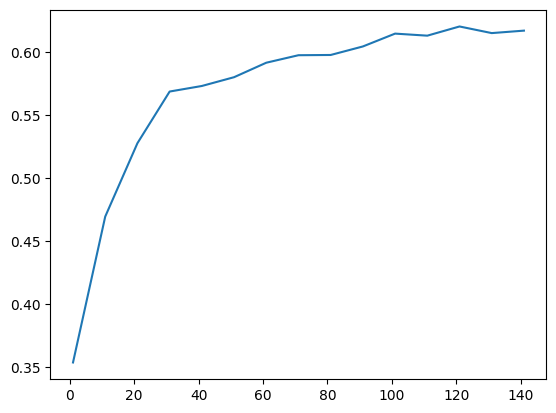

Epoch 142: 100%|██████████| 236/236 [00:08<00:00, 27.44it/s]


Cohen's Kappa: 0.6143


Epoch 143: 100%|██████████| 236/236 [00:08<00:00, 27.52it/s]


Cohen's Kappa: 0.6172


Epoch 144: 100%|██████████| 236/236 [00:08<00:00, 27.76it/s]


Cohen's Kappa: 0.6119


Epoch 145: 100%|██████████| 236/236 [00:08<00:00, 27.78it/s]


Cohen's Kappa: 0.6172


Epoch 146: 100%|██████████| 236/236 [00:08<00:00, 26.44it/s]


Cohen's Kappa: 0.6220


Epoch 147: 100%|██████████| 236/236 [00:08<00:00, 27.35it/s]


Cohen's Kappa: 0.6189


Epoch 148: 100%|██████████| 236/236 [00:08<00:00, 26.64it/s]


Cohen's Kappa: 0.5975


Epoch 149: 100%|██████████| 236/236 [00:08<00:00, 27.33it/s]


Cohen's Kappa: 0.6248


Epoch 150: 100%|██████████| 236/236 [00:08<00:00, 26.73it/s]


Cohen's Kappa: 0.6260


Epoch 151: 100%|██████████| 236/236 [00:08<00:00, 27.79it/s]


Cohen's Kappa: 0.6063


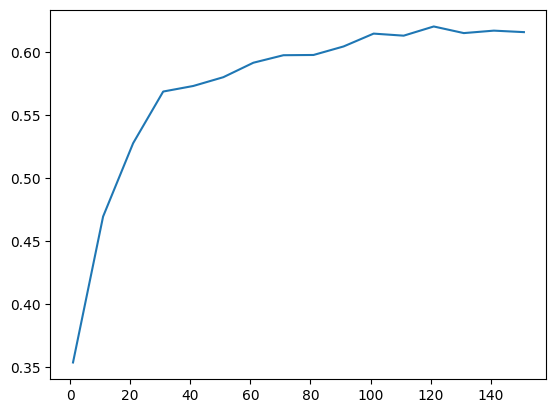

Epoch 152: 100%|██████████| 236/236 [00:08<00:00, 27.53it/s]


Cohen's Kappa: 0.6020


Epoch 153: 100%|██████████| 236/236 [00:08<00:00, 28.18it/s]


Cohen's Kappa: 0.6097


Epoch 154: 100%|██████████| 236/236 [00:08<00:00, 27.23it/s]


Cohen's Kappa: 0.5906


Epoch 155: 100%|██████████| 236/236 [00:08<00:00, 27.57it/s]


Cohen's Kappa: 0.6214


Epoch 156: 100%|██████████| 236/236 [00:08<00:00, 28.05it/s]


Cohen's Kappa: 0.6062


Epoch 157: 100%|██████████| 236/236 [00:08<00:00, 28.11it/s]


Cohen's Kappa: 0.6176


Epoch 158: 100%|██████████| 236/236 [00:08<00:00, 28.96it/s]


Cohen's Kappa: 0.6041


Epoch 159: 100%|██████████| 236/236 [00:06<00:00, 36.52it/s]


Cohen's Kappa: 0.6098


Epoch 160: 100%|██████████| 236/236 [00:06<00:00, 38.34it/s]


Cohen's Kappa: 0.5983


Epoch 161: 100%|██████████| 236/236 [00:06<00:00, 38.39it/s]


Cohen's Kappa: 0.6216


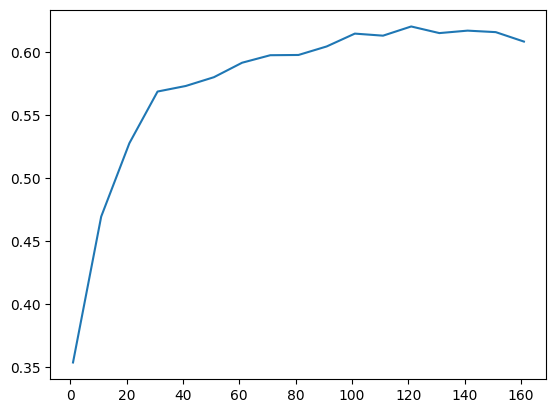

Epoch 162: 100%|██████████| 236/236 [00:06<00:00, 37.01it/s]


Cohen's Kappa: 0.6097


Epoch 163: 100%|██████████| 236/236 [00:06<00:00, 38.34it/s]


Cohen's Kappa: 0.6076


Epoch 164: 100%|██████████| 236/236 [00:06<00:00, 38.13it/s]


Cohen's Kappa: 0.6103


Epoch 165: 100%|██████████| 236/236 [00:06<00:00, 38.58it/s]


Cohen's Kappa: 0.6217


Epoch 166: 100%|██████████| 236/236 [00:06<00:00, 38.20it/s]


Cohen's Kappa: 0.6255


Epoch 167: 100%|██████████| 236/236 [00:06<00:00, 36.87it/s]


Cohen's Kappa: 0.6131


Epoch 168: 100%|██████████| 236/236 [00:06<00:00, 34.62it/s]


Cohen's Kappa: 0.6078


Epoch 169: 100%|██████████| 236/236 [00:06<00:00, 36.18it/s]


Cohen's Kappa: 0.6142


Epoch 170: 100%|██████████| 236/236 [00:06<00:00, 33.93it/s]


Cohen's Kappa: 0.6247


Epoch 171: 100%|██████████| 236/236 [00:06<00:00, 36.87it/s]


Cohen's Kappa: 0.6257


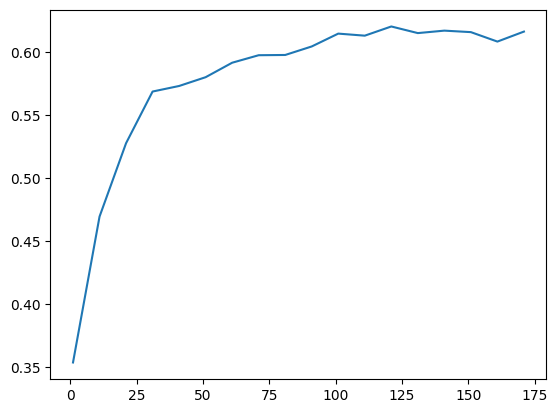

Epoch 172: 100%|██████████| 236/236 [00:06<00:00, 35.30it/s]


Cohen's Kappa: 0.6164


Epoch 173: 100%|██████████| 236/236 [00:06<00:00, 36.83it/s]


Cohen's Kappa: 0.6130


Epoch 174: 100%|██████████| 236/236 [00:07<00:00, 33.69it/s]


Cohen's Kappa: 0.6320


Epoch 175: 100%|██████████| 236/236 [00:06<00:00, 34.22it/s]


Cohen's Kappa: 0.6310


Epoch 176: 100%|██████████| 236/236 [00:06<00:00, 35.41it/s]


Cohen's Kappa: 0.6238


Epoch 177: 100%|██████████| 236/236 [00:06<00:00, 34.09it/s]


Cohen's Kappa: 0.6082


Epoch 178: 100%|██████████| 236/236 [00:08<00:00, 29.28it/s]


Cohen's Kappa: 0.6139


Epoch 179: 100%|██████████| 236/236 [00:08<00:00, 27.93it/s]


Cohen's Kappa: 0.6123


Epoch 180: 100%|██████████| 236/236 [00:06<00:00, 38.04it/s]


Cohen's Kappa: 0.6150


Epoch 181: 100%|██████████| 236/236 [00:06<00:00, 35.41it/s]


Cohen's Kappa: 0.6130


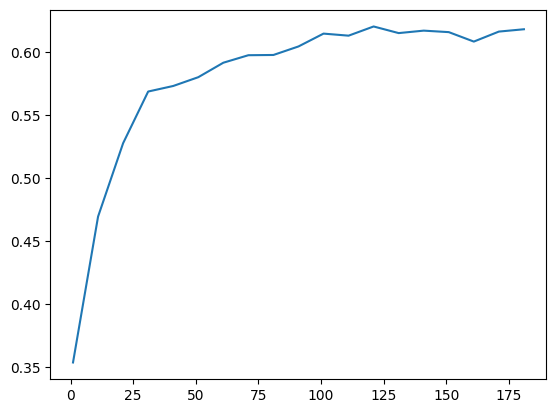

Epoch 182: 100%|██████████| 236/236 [00:07<00:00, 31.98it/s]


Cohen's Kappa: 0.6182


Epoch 183: 100%|██████████| 236/236 [00:06<00:00, 34.34it/s]


Cohen's Kappa: 0.6170


Epoch 184: 100%|██████████| 236/236 [00:06<00:00, 37.51it/s]


Cohen's Kappa: 0.6085


Epoch 185: 100%|██████████| 236/236 [00:06<00:00, 37.12it/s]


Cohen's Kappa: 0.6067


Epoch 186: 100%|██████████| 236/236 [00:06<00:00, 37.46it/s]


Cohen's Kappa: 0.6096


Epoch 187: 100%|██████████| 236/236 [00:06<00:00, 36.88it/s]


Cohen's Kappa: 0.6105


Epoch 188: 100%|██████████| 236/236 [00:06<00:00, 36.40it/s]


Cohen's Kappa: 0.6033


Epoch 189: 100%|██████████| 236/236 [00:06<00:00, 36.81it/s]


Cohen's Kappa: 0.6104


Epoch 190: 100%|██████████| 236/236 [00:06<00:00, 37.25it/s]


Cohen's Kappa: 0.6182


Epoch 191: 100%|██████████| 236/236 [00:06<00:00, 37.28it/s]


Cohen's Kappa: 0.5987


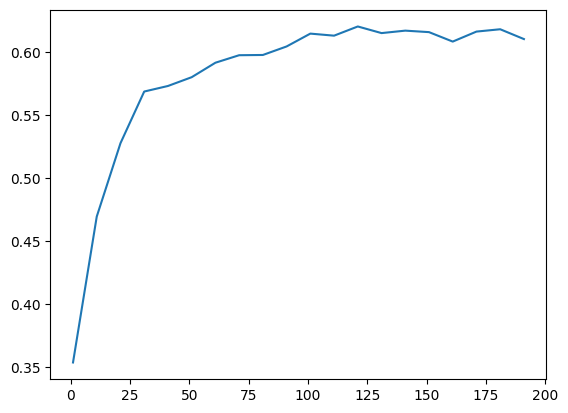

Epoch 192: 100%|██████████| 236/236 [00:06<00:00, 37.37it/s]


Cohen's Kappa: 0.6083


Epoch 193: 100%|██████████| 236/236 [00:06<00:00, 37.56it/s]


Cohen's Kappa: 0.6109


Epoch 194: 100%|██████████| 236/236 [00:06<00:00, 36.91it/s]


Cohen's Kappa: 0.5922


Epoch 195: 100%|██████████| 236/236 [00:06<00:00, 37.39it/s]


Cohen's Kappa: 0.6029


Epoch 196: 100%|██████████| 236/236 [00:06<00:00, 35.56it/s]


Cohen's Kappa: 0.6249


Epoch 197: 100%|██████████| 236/236 [00:06<00:00, 37.16it/s]


Cohen's Kappa: 0.6126


Epoch 198: 100%|██████████| 236/236 [00:06<00:00, 37.45it/s]


Cohen's Kappa: 0.6037


Epoch 199: 100%|██████████| 236/236 [00:06<00:00, 37.28it/s]


Cohen's Kappa: 0.6215


Epoch 200: 100%|██████████| 236/236 [00:06<00:00, 36.99it/s]


Cohen's Kappa: 0.6237


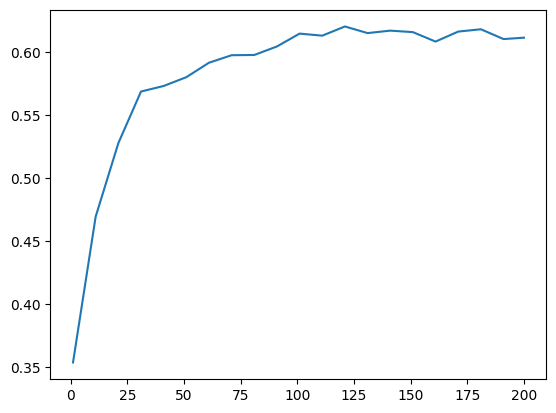

Cohen's Kappa: 0.6237


{'accuracy': 0.8120021242697822,
 'precision': 0.8135942327497425,
 'recall': 0.8203530633437176,
 'f1_score': 0.8169596690796277,
 'Cohens_kappa': np.float64(0.6237350246334338)}

In [38]:

data = pd.read_csv("data/train.csv")
smiles_list = data["smiles"].tolist()
y = data['class'].to_numpy()

# Convert to graph data

X, A, smiles_list = convert_to_graph(smiles_list)
indices = list(range(len(smiles_list)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=y)

# Appliquer le split sur les données
X_train, X_test = X[train_indices], X[test_indices]
A_train, A_test = A[train_indices], A[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

    # Model hyperparameters
num_features = X_train.shape[2]
gnn_params = {
        'num_features': num_features,
        'hidden_channels': 128,
        'num_gcn_layers': 4,
        'dnn_hidden_nodes': 512,
        'num_dnn_layers': 2,
        'dropout_rate': 0.33356257977269954,
        'l2_lambda': 0.0007517360053320633
    }

    # Prepare datasets
train_dataset = GraphDataset(X_train, A_train, y_train)
test_dataset = GraphDataset(X_test, A_test, y_test)
    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    # train model and save weights
model = GraphNeuralNetwork(**gnn_params)
model = train_graph_neural_network(model, train_loader,test_loader, val_loader=None, epochs=200, learning_rate=0.0001, weight_decay=1e-5, patience=100, save_path="DeepHIT/weights/best_gnn_2.pth")

    # # Evaluate the model
evaluate_graph_neural_network(model, test_loader)
